In [22]:
import os
import warnings

import pandas as pd
import numpy as np

from scipy.stats import gmean
from tqdm import tqdm

from jre_utils.datapath import (
    DATA_DIRECTORY_PATH,
    get_derived_csv_path,
)
from jre_utils.config import asset_types

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [23]:
def area_to_int(area):
    if area == "2,000 m^2 or greater.":
        return 2000
    elif area == "5000 m^2 or greater.":
        return 5000
    else:
        return int(area)

In [24]:
trade_prices_data_path = f"{DATA_DIRECTORY_PATH}/core"

trade_prices_data_paths = [
    f"{trade_prices_data_path}/{filename}"
    for filename in os.listdir(trade_prices_data_path)
]

In [25]:
req_int_columns = ["Transaction-price(total)", "Area(m^2)"]

req_float_columns = ["Transaction-price(Unit price m^2)"]

req_object_columns = [
    "City,Town,Ward,Village code",
    "Type",
    "Region",
    # "Area", finer grain than Municipality
    "Use",
    "Purpose of Use",
    "Transaction period",
]

required_columns = req_int_columns + req_float_columns + req_object_columns

float_filler = dict((col, 0) for col in req_float_columns)
int_filler = dict((col, 0) for col in req_int_columns)
object_filler = dict((col, "na") for col in req_object_columns)
na_filler = {**float_filler, **int_filler, **object_filler}

In [26]:
import json
from pprint import pprint

sub_city_to_city_path = f"{DATA_DIRECTORY_PATH}/core_scraped/sub_city_to_city.json"
with open(sub_city_to_city_path) as fd:
     sub_city_to_city = json.load(fd)
     pprint(f"E.g. Maps 1101 to {sub_city_to_city['1101']}")

area_code_to_area_path = f"{DATA_DIRECTORY_PATH}/core_scraped/area_code_to_area.json"
with open(area_code_to_area_path) as fd:
     area_code_to_area = json.load(fd)
     pprint(f"E.g. Maps 1100 to {area_code_to_area['1100']}") 

# In the future, we may want to use the 175 sub cities and just skip this
# Problem currently is that we don't have taxable income for sub cities
def get_city_code(area_code):
     return sub_city_to_city.get(area_code, area_code)

def get_area_from_area_code(area_code):
     return area_code_to_area.get(area_code, "na" )

'E.g. Maps 1101 to 1100'
'E.g. Maps 1100 to Hokkaido Sapporo-shi'


In [27]:
def custom_aggregate(x):
    d = {}
    d["unit_price_median"] = x["unit_price"].median()
    d["unit_price_gmean"] = gmean(x["unit_price"]) 
    d["count"] = x["count"].count()
    return pd.Series(
        d,
        index=[
            "unit_price_median",
            "unit_price_gmean",
            "count",
        ],
    )

def filter_df(df, latest_year):
    return df[
        (df["year"] <= latest_year)
        & (df["Region"] != "Industrial Area")
        & (
            ~df["Use"].str.contains(
                "Factory|Warehouse|Parking Lot", na=False, regex=True
            )
        )
        & (
            ~df["Purpose of Use"].str.contains(
                "Factory|Warehouse|Parking Lot", na=False, regex=True
            )
        )
    ]

In [28]:
derived_dfs = {"land": pd.DataFrame(), "building": pd.DataFrame(), "condo": pd.DataFrame()}
final_year = 2022

pbar = tqdm(total=len(trade_prices_data_paths))

for path in trade_prices_data_paths:
    main_df = pd.read_csv(path, usecols=required_columns, encoding="unicode_escape")
    main_df = main_df.assign(count=1)

    main_df["area_code"] = main_df["City,Town,Ward,Village code"].astype(str)

    # we may want to skip the following step in the future
    main_df["area_code"] = main_df["area_code"].apply(get_city_code).astype(str)
    main_df["area"] = main_df["area_code"].apply(get_area_from_area_code)

    main_df["trade_price"] = main_df["Transaction-price(total)"]
    main_df["trade_area"] = main_df["Area(m^2)"].apply(area_to_int)
    main_df["unit_price"] = main_df["Transaction-price(Unit price m^2)"]
    main_df["trade_price_per_area"] = main_df["trade_price"] / main_df["trade_area"]

    main_df["quarter"] = main_df["Transaction period"].apply(
        lambda x: int(x.split(" ")[0][0])
    )
    main_df["year"] = main_df["Transaction period"].apply(
        lambda x: int(x.split(" ")[2])
    )

    main_df["date"] = pd.PeriodIndex(
        year=main_df["year"], quarter=main_df["quarter"]
    ).to_timestamp()

    main_df["unit_price"] = np.where(
        main_df["unit_price"].isna(),
        main_df["trade_price_per_area"],
        main_df["unit_price"],
    )

    main_df = main_df.fillna(na_filler)

    for asset_type, asset_type_props in asset_types.items():
        df = main_df[main_df["Type"] == asset_type_props["label"]]

        # filter out unwanted transactions
        df = filter_df(df, final_year)

        # Aggregate
        df = (
            df.groupby(["year", "area_code", "area"])
            .apply(custom_aggregate)
            .reset_index()
        )
        
        df = df.sort_values(
            by=["year", "area_code"], ascending=[False, True]
        ).reset_index(drop=True)
        derived_dfs[asset_type] = pd.concat([derived_dfs[asset_type], df])

    pbar.update()
pbar.close()

100%|██████████| 47/47 [00:52<00:00,  1.12s/it]


In [29]:
# Drop Areas with non contiguous years
for asset_type in asset_types:
    df = derived_dfs[asset_type]
    cleaned_df = pd.DataFrame()

    for area_code in df["area_code"].unique():
        area_df = df[df["area_code"] == area_code]
        area_df = area_df.sort_values(by="year", ascending=True)

        year_min = area_df["year"].min()
        year_max = area_df["year"].max()
        
        # Skip if area_df is non contiguous
        if year_max - year_min + 1 != len(area_df):
            continue

        cleaned_df = pd.concat([cleaned_df, area_df])

    derived_dfs[asset_type] = cleaned_df

In [30]:
# Save derived dataframes
for asset_type, asset_type_props in asset_types.items():
    path = get_derived_csv_path(
        asset_type,
    )
    derived_dfs[asset_type].to_csv(
        path,
        index=False,
    )
    print(f"Wrote to {path}")

Wrote to ../../data/derived/transactions/land.csv
Wrote to ../../data/derived/transactions/building.csv
Wrote to ../../data/derived/transactions/condo.csv


In [ ]:
# For later
for asset_type in asset_types:
    derived_dfs[asset_type] = derived_dfs[asset_type].rename(
        columns={
            "unit_price_gmean": f"{asset_type}_unit_price_gmean",
            "unit_price_median": f"{asset_type}_unit_price_median",
            "count": f"{asset_type}_count",
        }
    )

combined_derived_dfs = pd.merge(
    derived_dfs["land"],
    derived_dfs["building"],
    on=["year", "area_code", "area"],
    how="outer",
)

combined_derived_dfs = pd.merge(
    combined_derived_dfs,
    derived_dfs["condo"],
    on=["year", "area_code", "area"],
    how="outer",
)

In [17]:
path = get_derived_csv_path(
    "building"
)
df = pd.read_csv(path)
df

,year,area_code,area,unit_price_wmean,unit_price_wmedian,unit_price_mean,unit_price_median,unit_price_gmean,total_traded_area,count,unit_price_wmean_smoothed,unit_price_wmedian_smoothed,unit_price_mean_smoothed,unit_price_median_smoothed,unit_price_gmean_smoothed
0,2007,30201,Wakayama-ken Wakayama-shi,143912.855444,123243.229639,152399.716362,139393.939394,118952.327531,46245.0,225.0,147368.641049,124393.313464,152399.716362,135454.168663,118952.327531
1,2008,30201,Wakayama-ken Wakayama-shi,149960.106383,111111.111111,145193.478174,121320.346320,108058.169252,48880.0,298.0,140311.323549,108625.435717,145193.478174,126675.756452,108058.169252
2,2009,30201,Wakayama-ken Wakayama-shi,107838.303201,90054.858934,124602.333156,113484.848485,95880.223355,63885.0,342.0,133637.240939,90067.040315,136130.767150,119677.626927,102928.125162
3,2010,30201,Wakayama-ken Wakayama-shi,124351.827541,113043.478261,126744.387875,127525.252525,97614.865211,72365.0,368.0,118878.557549,87466.450439,126744.387875,120193.088831,97614.865211
4,2011,30201,Wakayama-ken Wakayama-shi,103181.027668,84966.791200,119643.063764,117777.777778,92257.285648,63250.0,329.0,109575.160742,84965.973974,123165.447934,120619.316569,94239.844512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18070,2018,36403,Tokushima-ken Aizumi-cho,100219.435737,83456.739339,117241.056248,121120.689655,102005.341358,6380.0,28.0,100046.815595,83008.044262,104414.051274,111524.332642,91047.007641
18071,2019,36403,Tokushima-ken Aizumi-cho,118959.390863,135405.821846,107032.010167,112121.212121,91571.280258,3940.0,18.0,88203.637850,63491.483188,107121.230764,113554.169509,92819.579374
18072,2020,36403,Tokushima-ken Aizumi-cho,75043.478261,41624.774069,103179.889603,107692.307692,85340.432024,6900.0,25.0,75035.613786,41619.640743,103177.989281,107678.014235,78004.080276
18073,2021,36403,Tokushima-ken Aizumi-cho,67849.355798,52738.222919,70876.555710,56964.809384,54207.885824,5045.0,26.0,78765.481162,58894.584314,98240.958226,94426.894948,63413.145789


In [18]:
# test_area = "1100" # Hokkaido Sapporo-shi
test_area = 13103 # Tokyo-to Chuo-ku

In [19]:
area_df = df[df["area_code"] == test_area][["year", "area_code", "area", "unit_price_median"]]
area_df["yearly_price_change"] = area_df["unit_price_median"].pct_change()
# area_df.round(2).to_csv("test.csv", index=False)
area_df

,year,area_code,area,unit_price_median,yearly_price_change
1614,2005,13103,Tokyo-to Minato-ku,1.703297e+06,NaN
1615,2006,13103,Tokyo-to Minato-ku,2.462121e+06,0.445503
1616,2007,13103,Tokyo-to Minato-ku,2.631579e+06,0.068826
1617,2008,13103,Tokyo-to Minato-ku,2.340426e+06,-0.110638
1618,2009,13103,Tokyo-to Minato-ku,1.522727e+06,-0.349380
1619,2010,13103,Tokyo-to Minato-ku,1.413636e+06,-0.071642
1620,2011,13103,Tokyo-to Minato-ku,1.487805e+06,0.052466
1621,2012,13103,Tokyo-to Minato-ku,1.377470e+06,-0.074159
1622,2013,13103,Tokyo-to Minato-ku,1.391304e+06,0.010043
1623,2014,13103,Tokyo-to Minato-ku,1.627119e+06,0.169492


<Axes: xlabel='year'>

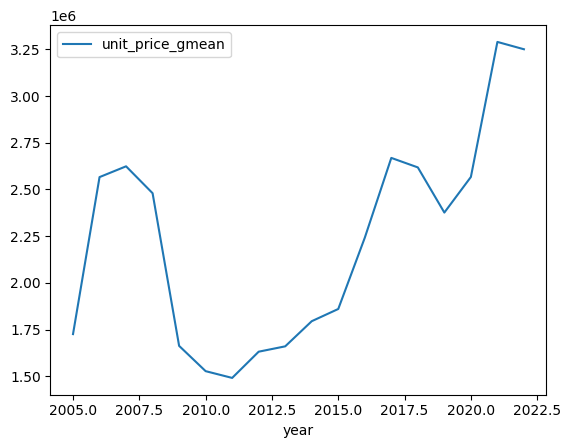

In [20]:
# gmean
df[df["area_code"] == test_area].plot(x="year", y="unit_price_gmean")x

<Axes: xlabel='year'>

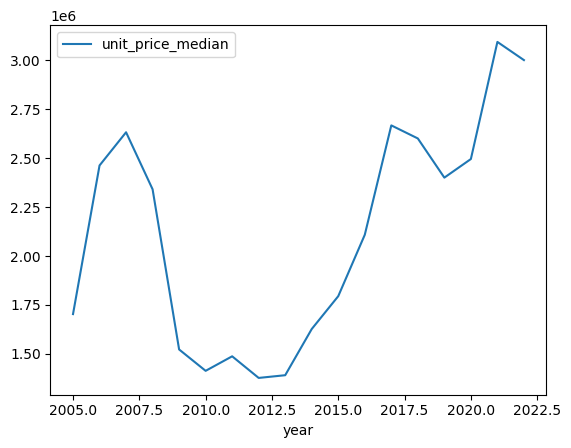

In [16]:
# median
df[df["area_code"] == test_area].plot(x="year", y="unit_price_median")

<Axes: xlabel='year'>

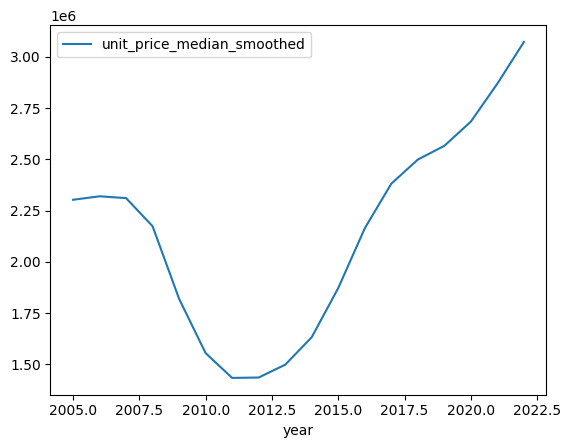

In [17]:
# median
df[df["area_code"] == test_area].plot(x="year", y="unit_price_median_smoothed")

<Axes: xlabel='year'>

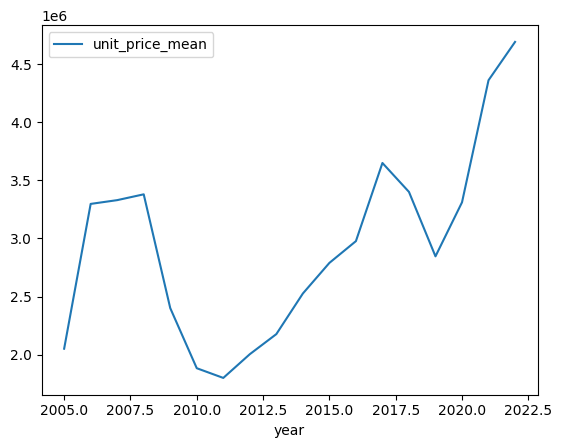

In [18]:
# mean
df[df["area_code"] == test_area].plot(x="year", y="unit_price_mean")

<Axes: xlabel='year'>

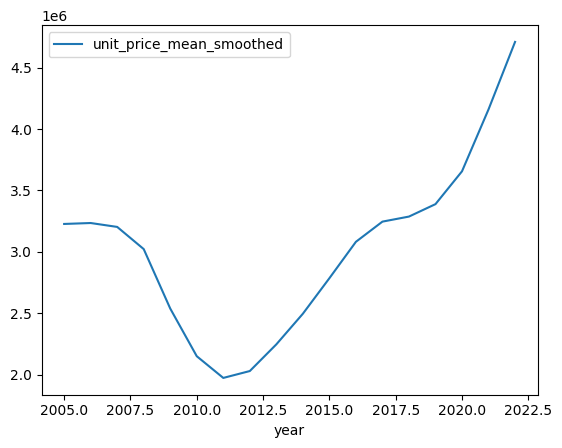

In [19]:
# mean
df[df["area_code"] == test_area].plot(x="year", y="unit_price_mean_smoothed")

<Axes: xlabel='year'>

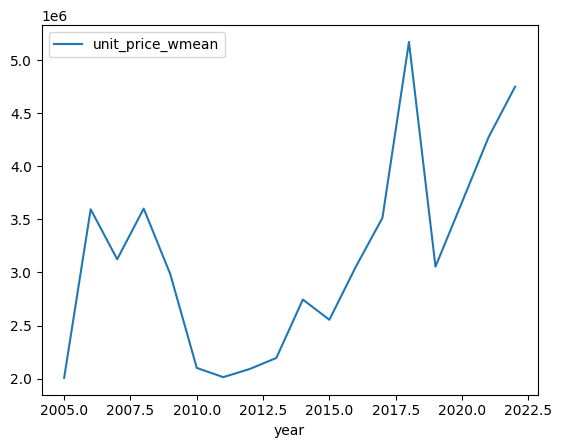

In [20]:
# weighted mean - this makes the most sense. Prices wouldn't be on the decline before the financial crisis
df[df["area_code"] == test_area].plot(x="year", y="unit_price_wmean")

<Axes: xlabel='year'>

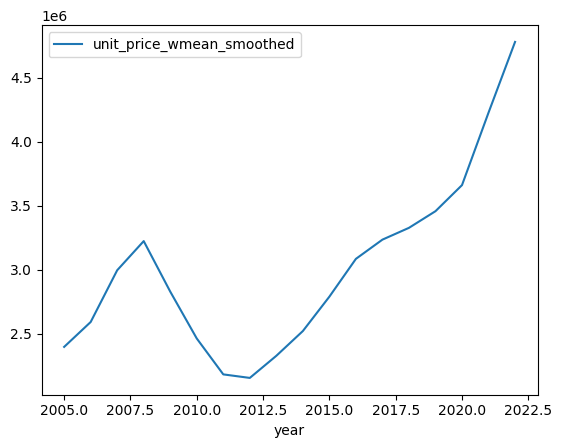

In [21]:
df[df["area_code"] == test_area].plot(x="year", y="unit_price_wmean_smoothed")

<Axes: xlabel='year'>

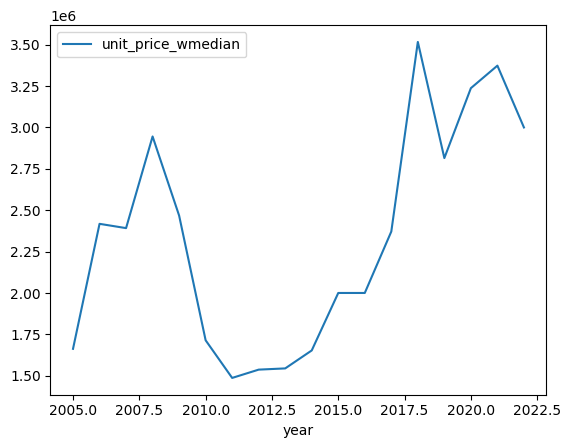

In [22]:
df[df["area_code"] == test_area].plot(x="year", y="unit_price_wmedian")

<Axes: xlabel='year'>

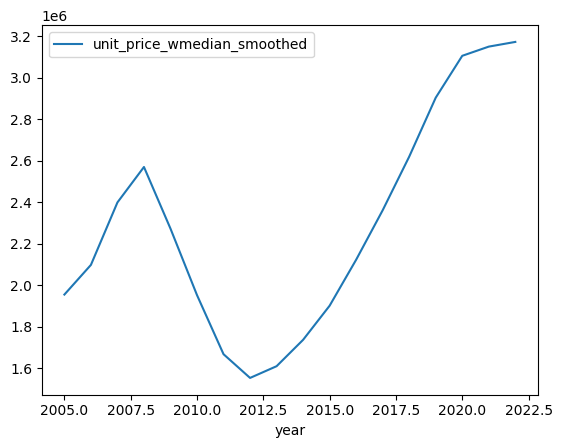

In [23]:
df[df["area_code"] == test_area].plot(x="year", y="unit_price_wmedian_smoothed")